In [38]:
# Import the neccessary libraries and packages
import tensorflow as tf

import pandas as pd
import numpy as np

import os
import glob
import matplotlib.pyplot as plt


# ************************************** Method to access data files ********************************************
# ***************************************************************************************************************

# Read the dataset
def read_data(file_path):
    dfs = pd.DataFrame()

    # Retrieve all CSV file from 'sample_data' folder
    file_names = glob.glob(file_path + '*.csv')

    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs = pd.concat([dfs, df], ignore_index=True)
        del df

    # Remove the '_' (uderscore) with from 'event_value' column
    dfs['event_value'] = dfs['event_value'].str.replace('_', '')

    return dfs


# ******************************** Method to generate corpus from the dataframe **********************************
# ****************************************************************************************************************

def generate_corpus(df, sentence_size):
    # Data Preprocessing
    corpus_ = df['event_value'].values.flatten()

    corpus = []
    sentence_size = sentence_size
    count = 0
    temp_sentence = ''

    for item in corpus_:
        count += 1
        if count < sentence_size:
            temp_sentence += item + ' '
        else:
            temp_sentence += item
            corpus.append(temp_sentence)
            temp_sentence = ''
            count = 0

    return corpus


# *********************************** Method to split train and validation sets **********************************
# ****************************************************************************************************************

def train_val_split(sentences, training_split):
    # compute the number (an integer) of sentences that will be used for training
    train_size = int(len(sentences) * training_split)

    # split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    validation_sentences = sentences[train_size:]

    return train_sentences, validation_sentences


# ****************************** Method to return a tokenizer fitted into train_sentences ************************
# ****************************************************************************************************************

def fit_tokenizer(train_sentences):
    # Create tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(train_sentences)

    # Define the total words. Add 1 for the index `0` which is just the padding token.
    total_words = len(tokenizer.word_index) + 1

    return tokenizer, total_words


# ******************************* Method to return padded sequences and labels ***********************************
# ****************************************************************************************************************
def data_preprocessing(sentences, tokenizer, total_words):
    # Initialize the sequences list
    input_sequences = []

    # Loop over the line several times to generate the subphrases
    for line in sentences:
        # Tokenize the current line
        token_list = tokenizer.texts_to_sequences([line])[0]

        for i in range(1, len(token_list)):
            # Generate the subphrase
            n_gram_sequence = token_list[:i + 1]

            # Append the subphrase to the sequences list
            input_sequences.append(n_gram_sequence)

    # Get the length of the longest line
    max_sequence_len = max([len(x) for x in input_sequences])

    padded_sequenes = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
    # Pad all sequences
    input_sequences = np.array(padded_sequenes)

    # Create inputs and label by splitting the last token in the subphrases
    xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

    # Convert the label into one-hot arrays
    ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    return xs, ys, max_sequence_len


# ******************************** Method to build the neural network model **************************************
# ****************************************************************************************************************

# Build the model
def build_model(max_sequence_len, total_words):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(total_words, 128, input_length=max_sequence_len - 1),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(total_words, activation='softmax')
    ])

    # Use categorical crossentropy because this is a multi-class problem
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    print('\nModel Summary:')
    model.summary()

    return model


# **************************************** Method to predict next words ******************************************
# ****************************************************************************************************************

def predict_text(seed, tokenizer, model, max_sequence_len, next_words):
    # Define seed text
    seed_text = seed
    prediction = [seed_text]

    # Define total words to predict
    next_words = next_words

    # Loop until desired length is reached
    for _ in range(next_words):

        # Convert the seed text to a token sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the sequence
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Feed to the model and get the probabilities for each index
        probabilities = model.predict(token_list)

        # Get the index with the highest probability
        predicted = np.argmax(probabilities, axis=-1)[0]

        # Ignore if index is 0 because that is just the padding.
        if predicted != 0:
            # Look up the word associated with the index.
            output_word = tokenizer.index_word[predicted]

            # Combine with the seed text
            seed_text += " " + output_word
            prediction.append(output_word)

    prediction_unique = []
    for item in prediction:
        if item not in prediction_unique:
            # append only the unique words
            prediction_unique.append(item)

    return prediction, prediction_unique



# ****************************************************************************************************************
# ****************************************************************************************************************

def main():
    # Read the data
    file_path = os.path.join(os.getcwd(), 'Data/v1/')
    df = read_data(file_path)

    print(True)

    # generate the corpus
    sentence_size = 227
    sentences = generate_corpus(df, sentence_size)

    # set the split size and split the corpus
    training_split = 0.8
    train_sentences, validation_sentences = train_val_split(sentences, training_split)

    # get a fitted tokenizer and the tota number of words in the vocab
    tokenizer, total_words = fit_tokenizer(train_sentences)

    # get processed and padded sequences for both train_sentences and validation_sentences
    X_train, y_train, max_sequence_len = data_preprocessing(train_sentences, tokenizer, total_words)
    X_valid, y_valid, max_sequence_len = data_preprocessing(validation_sentences, tokenizer, total_words)

    # get the neural network model
    model = build_model(max_sequence_len, total_words)

    # set hyperparameters
    epochs = 100
    next_words = 500

    # Train the model
    print('\nTraining Time!')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))
    
    return history


In [39]:
# ****************************************************************************************************************
# ****************************************************************************************************************

if __name__ == '__main__':
    history = main()

True

Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 226, 128)          2944      
                                                                 
 bidirectional_4 (Bidirectio  (None, 226, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 23)                1495      
                                                                 
Total params: 144,471
Trainable params: 144,471
Non-trainable params: 0
_________________________________________________________________

Training Time!
Epoch 1/100

184/184 [==============================] - 20s 108ms/step - loss: 0.0147 - accuracy: 0.9986 - val_loss: 0.0134 - val_accuracy: 0.9956
Epoch 50/100
184/184 [==============================] - 20s 108ms/step - loss: 0.0118 - accuracy: 0.9986 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 51/100
184/184 [==============================] - 20s 108ms/step - loss: 0.0101 - accuracy: 0.9985 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 52/100
184/184 [==============================] - 20s 109ms/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 53/100
184/184 [==============================] - 20s 109ms/step - loss: 0.0080 - accuracy: 0.9986 - val_loss: 0.0103 - val_accuracy: 0.9956
Epoch 54/100
184/184 [==============================] - 20s 109ms/step - loss: 0.0074 - accuracy: 0.9986 - val_loss: 0.0086 - val_accuracy: 0.9956
Epoch 55/100
184/184 [==============================] - 20s 108ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0056 - val_a

In [48]:
# *********************************** Method to evaluate accuracy **************************************
# ****************************************************************************************************************
def evaluate_model_accuracy(history):
    # Check how accuracy and loss changes over the training epochs

    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(6, 4))

    plt.subplot(1, 1, 1)
    plt.plot(range(0, len(epoch_accuracy)), epoch_accuracy, 'b-', linewidth=1, label='Training Accuracy')
    plt.plot(range(0, len(epoch_val_accuracy)), epoch_val_accuracy, 'r-', linewidth=1, label='Validation Accuracy')
#     plt.title('a) Training & validation accuracy over epochs', loc='center', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='best')

    # Enabling both grid lines:
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.5)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.9)
    plt.minorticks_on()
    plt.tick_params(which="minor", bottom=False, left=False)
#     plt.savefig("latest_result/temp/accuracy_plot.png")
    plt.savefig("latest_result/temp/accuracy_plot.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

In [49]:
# *********************************** Method to evaluate loss **************************************
# ****************************************************************************************************************
def evaluate_model_loss(history):
    # Check how loss changes over the training epochs
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']

    plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=1, label='Training Loss')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=1, label='Validation Loss')
#     plt.title('Training & validation loss over epochs', loc='center', pad=20 )
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='best')

    # Enabling both grid lines:
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.5)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.9)
    plt.minorticks_on()
    plt.tick_params(which="minor", bottom=False, left=False)

#     plt.savefig("latest_result/temp/loss_plot.png")
    plt.savefig("latest_result/temp/loss_plot.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

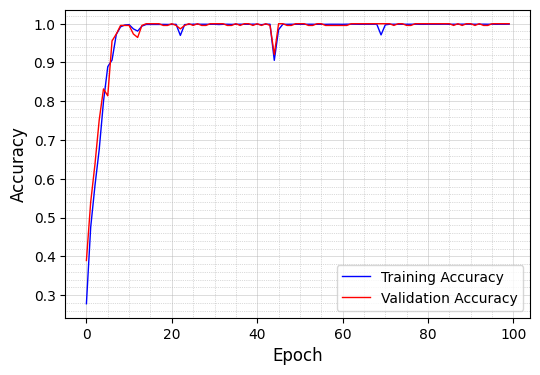

In [50]:
# check how accuracy & loss changes over epochs during the training process
evaluate_model_accuracy(history)

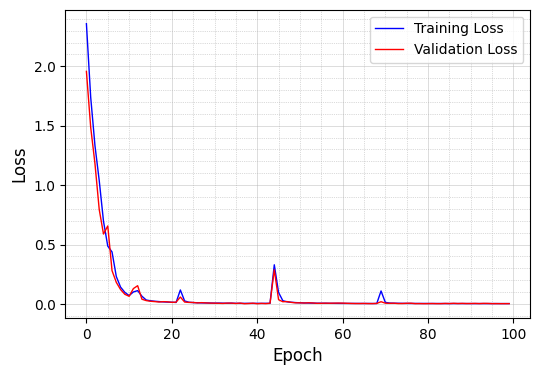

In [51]:
evaluate_model_loss(history)